# Installing required packages

In [ ]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 29.3 MB/s eta 0:00:00


In [ ]:
pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 5.2 MB/s eta 0:00:00


# Importing required packages

In [ ]:
# general purpose packages
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import emoji
import seaborn as sns
import re, string
import nltk

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB

# transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

# keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

# metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

# set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

#set seed for reproducibility
seed=42

<ipython-input-3-600702d4e559>:32: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


<Figure size 640x480 with 0 Axes>

### Confusion Matrix Visualization for Sentiment Analysis Function

In [ ]:
def conf_matrix(y, y_pred, title):
    fig, ax =plt.subplots(figsize=(5,5))
    labels=['Negative', 'Neutral', 'Positive']
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17)
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Test', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)
    plt.show()

# Importing the dataset

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
df = pd.read_csv("/content/gdrive/MyDrive/datasets/corona_NLP/Corona_NLP_train.csv", encoding='ISO-8859-1')
df_test = pd.read_csv("/content/gdrive/MyDrive/datasets/corona_NLP/Corona_NLP_test.csv")

## Basic data analysis

In [ ]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [ ]:
df['TweetAt'] = pd.to_datetime(df['TweetAt'])

<ipython-input-9-45b9b0fe6852>:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['TweetAt'] = pd.to_datetime(df['TweetAt'])


In [ ]:
df.drop_duplicates(subset='OriginalTweet',inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   UserName       41157 non-null  int64         
 1   ScreenName     41157 non-null  int64         
 2   Location       32567 non-null  object        
 3   TweetAt        41157 non-null  datetime64[ns]
 4   OriginalTweet  41157 non-null  object        
 5   Sentiment      41157 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 2.2+ MB


In [ ]:
tweets_per_day = df['TweetAt'].dt.strftime('%m-%d').value_counts().sort_index().reset_index(name='counts')

<ipython-input-13-02cd92b1f0e4>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  ax = sns.barplot(x='index', y='counts', data=tweets_per_day,edgecolor = 'black',ci=False, palette='Blues_r')


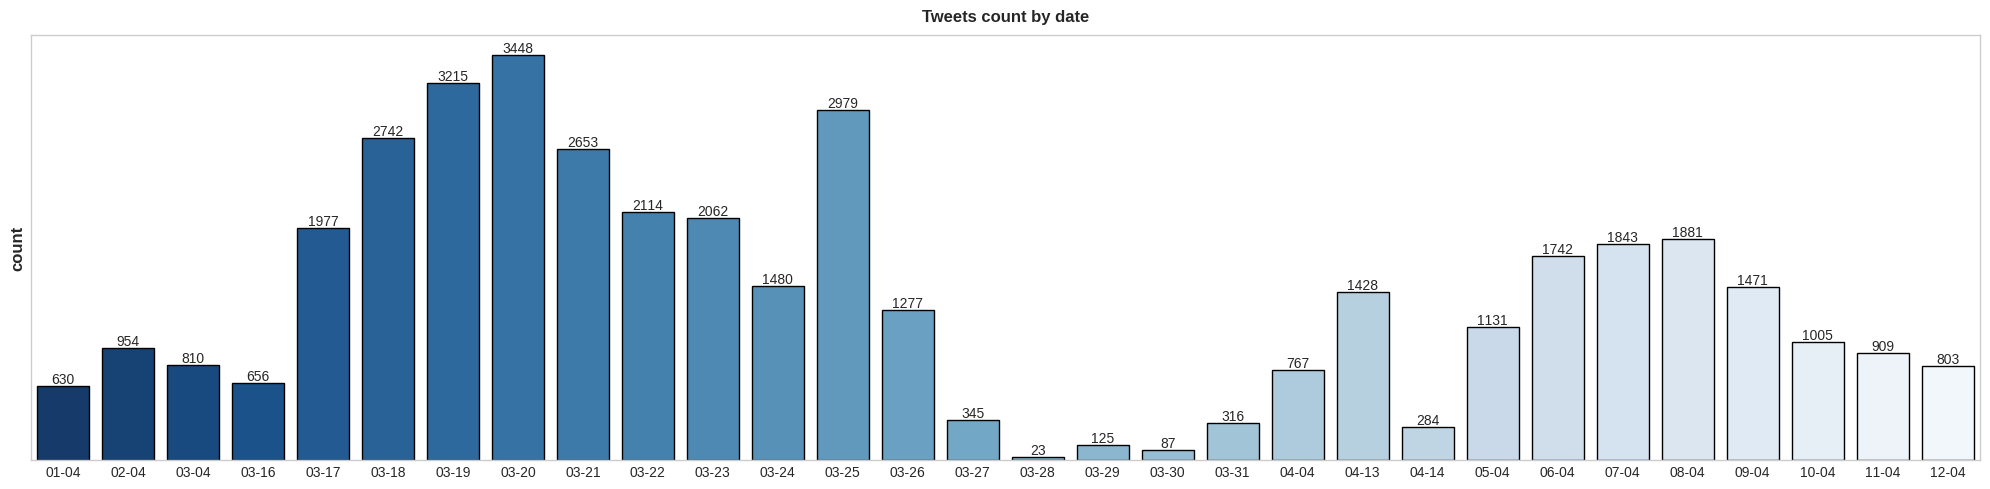

In [ ]:
plt.figure(figsize=(20,5))
ax = sns.barplot(x='index', y='counts', data=tweets_per_day,edgecolor = 'black',ci=False, palette='Blues_r')
plt.title('Tweets count by date')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [ ]:
tweets_per_country = df['Location'].value_counts().loc[lambda x : x > 100].reset_index(name='counts')

<ipython-input-15-8598a10c71b2>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  ax = sns.barplot(x='index', y='counts', data=tweets_per_country,edgecolor = 'black',ci=False, palette='Spectral')


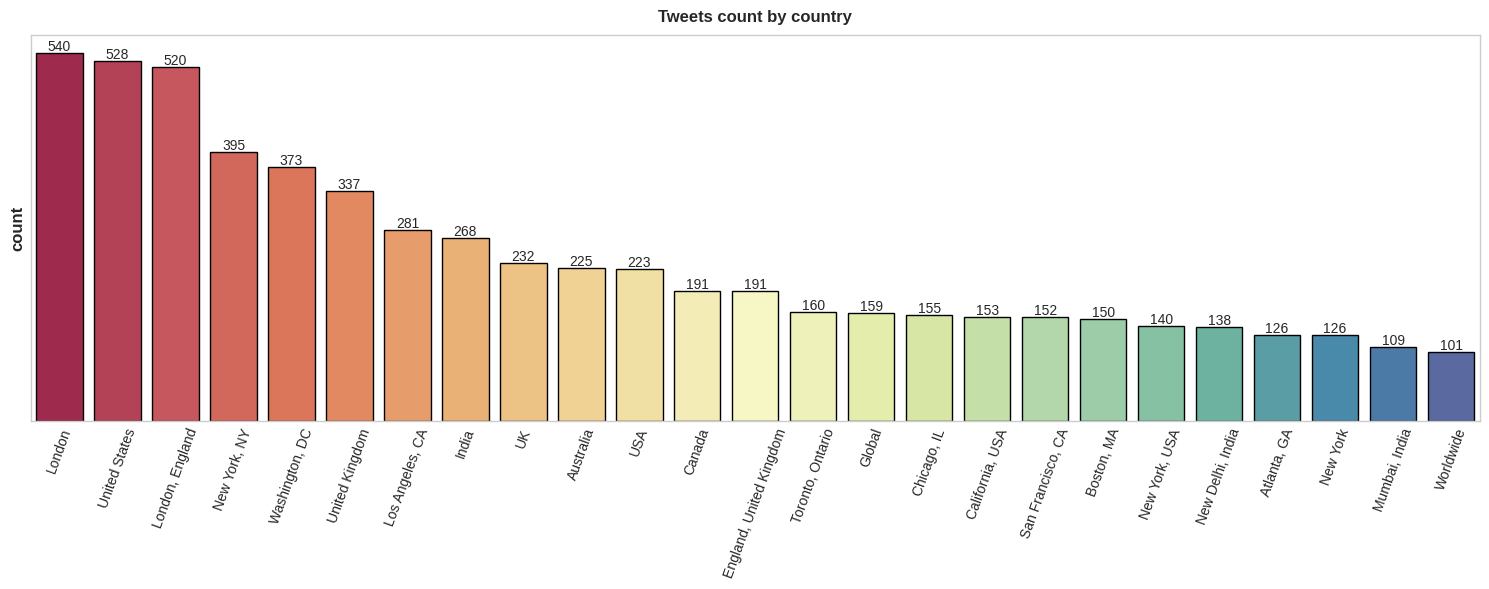

In [ ]:
plt.figure(figsize=(15,6))
ax = sns.barplot(x='index', y='counts', data=tweets_per_country,edgecolor = 'black',ci=False, palette='Spectral')
plt.title('Tweets count by country')
plt.xticks(rotation=70)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

## Tweets deep cleaning

In [ ]:
df = df[['OriginalTweet','Sentiment']]

In [ ]:
df_test = df_test[['OriginalTweet','Sentiment']]

In [ ]:
##CUSTOM DEFINED FUNCTIONS TO CLEAN THE TWEETS

# Remove emojis from text using regular expression
def strip_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F700-\U0001F77F"  # alchemical symbols
                           u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                           u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                           u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                           u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                           u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                           u"\U0001FB00-\U0001FBFF"  # Symbols for Legacy Computing
                           u"\U0001F004-\U0001F0CF"  # Miscellaneous Symbols and Pictographs
                           u"\U0001F200-\U0001F251"  # Enclosed Ideographic Supplement
                           u"\U0001F300-\U0001F5FF"  # Miscellaneous Symbols
                           u"\U0001F600-\U0001F64F"  # Emoticons
                           u"\U0001F680-\U0001F6FF"  # Transport & Map Symbols
                           u"\U0001F700-\U0001F77F"  # Alchemical Symbols
                           u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                           u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                           u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                           u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                           u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                           u"\U0001FB00-\U0001FBFF"  # Symbols for Legacy Computing"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r"", text)

#Removing punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text):
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#Cleaning hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
          sent.append(word)
    return ' '.join(sent)

#Remove multiple spaces
def remove_mult_spaces(text):
    return re.sub("\s\s+" , " ", text)

In [ ]:
texts_new = []
for t in df.OriginalTweet:
    texts_new.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

In [ ]:
texts_new_test = []
for t in df_test.OriginalTweet:
    texts_new_test.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

In [ ]:
df['text_clean'] = texts_new
df_test['text_clean'] = texts_new_test

In [ ]:
df_test['text_clean'].head()

0    trending new yorkers encounter empty supermark...
1    when i couldnt find hand sanitizer at fred mey...
2    find out how you can protect yourself and love...
3    panic buying hits newyork city as anxious shop...
4    toiletpaper dunnypaper coronavirus coronavirus...
Name: text_clean, dtype: object

In [ ]:
df['text_clean'][1:8].values

array(['advice talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist gp set up online shopping accounts if poss adequate supplies of regular meds but not over order',
       'coronavirus australia woolworths to give elderly disabled dedicated shopping hours amid covid19 outbreak',
       'my food stock is not the only one which is empty please dont panic there will be enough food for everyone if you do not take more than you need stay calm stay safe covid19france covid19 covid19 coronavirus confinement confinementotal confinementgeneral',
       'me ready to go at supermarket during the covid19 outbreak not because im paranoid but because my food stock is litteraly empty the coronavirus is a serious thing but please dont panic it causes shortage coronavirusfrance restezchezvous stayathome confinement',
       'as news of the regions first confirmed covid19 case came out of sullivan county last week people 

In [ ]:
text_len = []
for text in df.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [ ]:
df['text_len'] = text_len

In [ ]:
text_len_test = []
for text in df_test.text_clean:
    tweet_len = len(text.split())
    text_len_test.append(tweet_len)

In [ ]:
df_test['text_len'] = text_len_test

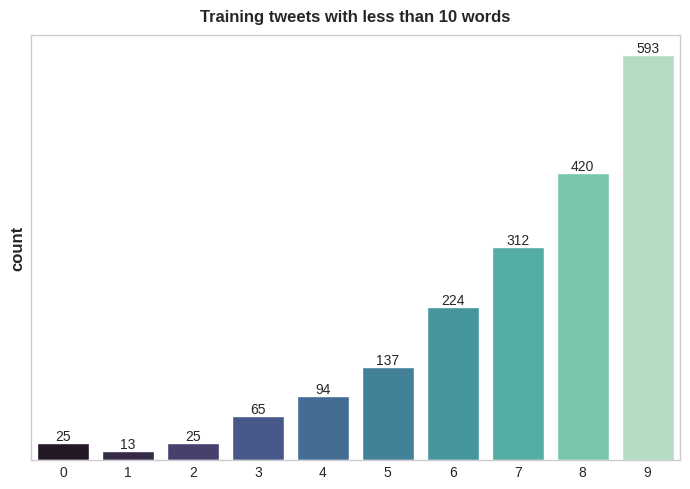

In [ ]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')
plt.title('Training tweets with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

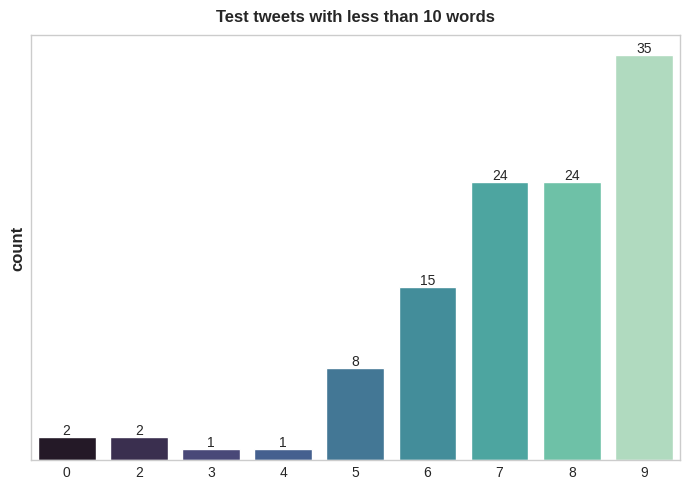

In [ ]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df_test[df_test['text_len']<10], palette='mako')
plt.title('Test tweets with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [ ]:
print(f" DF SHAPE: {df.shape}")
print(f" DF TEST SHAPE: {df_test.shape}")

 DF SHAPE: (41157, 4)
 DF TEST SHAPE: (3798, 4)


In [ ]:
df = df[df['text_len'] > 4]

In [ ]:
df_test = df_test[df_test['text_len'] > 4]

In [ ]:
print(f" DF SHAPE: {df.shape}")
print(f" DF TEST SHAPE: {df_test.shape}")

 DF SHAPE: (40935, 4)
 DF TEST SHAPE: (3792, 4)


In [ ]:
df.head

<bound method NDFrame.head of                                            OriginalTweet           Sentiment  \
1      advice Talk to your neighbours family to excha...            Positive   
2      Coronavirus Australia: Woolworths to give elde...            Positive   
3      My food stock is not the only one which is emp...            Positive   
4      Me, ready to go at supermarket during the #COV...  Extremely Negative   
5      As news of the regionÂs first confirmed COVID...            Positive   
...                                                  ...                 ...   
41152  Airline pilots offering to stock supermarket s...             Neutral   
41153  Response to complaint not provided citing COVI...  Extremely Negative   
41154  You know itÂs getting tough when @KameronWild...            Positive   
41155  Is it wrong that the smell of hand sanitizer i...             Neutral   
41156  @TartiiCat Well new/used Rift S are going for ...            Negative   

         

## Training data deeper cleaning

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [ ]:
token_lens = []

for txt in df['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

max_len=np.max(token_lens)

In [ ]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 100


In [ ]:
token_lens = []

for i,txt in enumerate(df['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")

INDEX: 1622, TEXT: zsah policie proti spekulantm s roukami na mj popud hejtman steckho kraje ve spoluprci s podle krizovho zkona zajistil tm 700 tisrouek od firmy kter je mla dodat na zdravotnkm ale na posledn chvli se snaila navyovat cenu spolutozvladneme
INDEX: 13623, TEXT: hoy aplaudo a mi segunda familia aplaudoanuestrosheroes aquellos con los que he compartido tantas noches de trabajo y tanta alegra s que como siempre dan todo por el bien de su comunidad presidente por ellos tambin cuarentenanacionalya cuidemosalosquecuidan
INDEX: 16548, TEXT: bir mddettir spermarketlerin lojistik hizmeti avusturya ordusu desteiyle yaplyor dn corona tedavisi iin 22 milyon luk bir aratrma gelitirme btesi aklad hkmet geen hafta da 35 milyon luk 2 yardm paketi aklanmt viyanadan haberler bu kadar
INDEX: 36953, TEXT: 11 nisan cumartesi itibariyle bbnin tm hizmetleri sokaa kma serbestisi olanlar iin devam edecek halk ekmek ve hamidiye su 100 retime geti bb tm stanbulun gda ihtiyacna yetecek kapasitededi

In [ ]:
df['token_lens'] = token_lens

In [ ]:
df = df.sort_values(by='token_lens', ascending=False)
df.head(20)

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
1638,ZÃ¡sah policie proti spekulant?m s rouÂkami. ...,Neutral,zsah policie proti spekulantm s roukami na mj ...,39,100
37156,11 Nisan Cumartesi itibariyle ?BBÂnin tÃ¼m hi...,Neutral,11 nisan cumartesi itibariyle bbnin tm hizmetl...,39,98
16632,Bir mÃ¼ddettir sÃ¼permarketlerin lojistik hizm...,Neutral,bir mddettir spermarketlerin lojistik hizmeti ...,36,92
13691,Hoy aplaudo a mi segunda familia #AplaudoANues...,Neutral,hoy aplaudo a mi segunda familia aplaudoanuest...,38,84
27005,Supermercados Econo confirman que un empleado ...,Neutral,supermercados econo confirman que un empleado ...,39,80
14593,"Na, wer war denn da am Werk? Gestern Nachmitta...",Extremely Negative,na wer war denn da am werk gestern nachmittag ...,37,80
28899,Kindly contact Us bamy global merchandise for ...,Positive,kindly contact us bamy global merchandise for ...,37,80
11213,Keine WertgegenstÃ¤nde im Fahrzeug lassen! - D...,Negative,keine wertgegenstnde im fahrzeug lassen diesen...,33,79
4844,Impct of #coronavirus i hve sen hw civilizd pp...,Extremely Negative,impct of coronavirus i hve sen hw civilizd ppl...,48,79
18913,#CroozefmNews \r\r\nPresident Museveni has ord...,Extremely Negative,croozefmnews president museveni has ordered th...,35,79


In [ ]:
df = df.iloc[12:]
df.head()

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
12389,"Okay, so I just checked the drug prices for #P...",Positive,okay so i just checked the drug prices for pla...,35,77
1697,I work at a grocery store.\r\r\nWe wont get an...,Positive,i work at a grocery store we wont get any toil...,37,77
8730,?Bitte anschauen! (1/2)\r\r\n\r\r\nEmotionaler...,Negative,bitte anschauen 12 emotionaler aufruf von geha...,36,77
14582,hiked prices in the face of the Covid-19 crise...,Negative,hiked prices in the face of the covid19 crises...,47,77
36305,Sterile disposable anti bacterial wet wipes an...,Negative,sterile disposable anti bacterial wet wipes an...,31,76


In [ ]:
df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
token_lens_test = []

for txt in df_test['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))

max_len=np.max(token_lens_test)

In [ ]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 96


In [ ]:
token_lens_test = []

for i,txt in enumerate(df_test['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")

INDEX: 286, TEXT: so hard to decide as much as i want to hodl my 2 ccdcv4 token our place is declared to lock down due to covid19 i will use this to buy some food to stock txnid093bd1db0c0d3a62af15883138a5f57d4cef35ae14e31e602b74489dd2524c7f my b
INDEX: 345, TEXT: informoval jsem zstupce vech obchodnch etzc o aktulnch opatench vldy etzce jsou zsobovny na 95 take nen dvod panikait zsoby potravin fakt nedojdou nen opravdu dvod dnes obsadit a vykoupit supermarkety
INDEX: 2380, TEXT: ahora seguid llorando por el papel higinico que no he comprado porque an tengo seguid creando histeria y preocupacin poniendo fotos de gente en pnico y estanteras vacas que yo seguir yendo a comercios responsables de barrio donde nos cuidan hoy y siempre gracias


In [ ]:
df_test['token_lens'] = token_lens_test

In [ ]:
df_test = df_test.sort_values(by='token_lens', ascending=False)
df_test.head(10)

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
286,@Rhett800cc So hard to decide??. As much as I ...,Negative,so hard to decide as much as i want to hodl my...,38,96
2383,Ahora seguid llorando por el papel higiénico (...,Negative,ahora seguid llorando por el papel higinico qu...,44,94
345,Informoval jsem zástupce vech obchodních ?et?...,Neutral,informoval jsem zstupce vech obchodnch etzc o ...,31,86
1485,DTF-Dont Touch Face\r\r\nDWBH-Do Wash Both Ha...,Extremely Negative,dtfdont touch face dwbhdo wash both hands gtfo...,42,77
1209,Im in the DC/Maryland/Virginia (DMV) area &am...,Positive,im in the dcmarylandvirginia dmv area amphave ...,45,74
3505,Stop misusing ur privilege amp grow up Some1 c...,Positive,stop misusing ur privilege amp grow up some1 c...,57,73
1789,"For those that are cashlong, patient,calm&amp;...",Extremely Positive,for those that are cashlong patientcalmamphave...,44,71
855,"Lidl is total chaos, queues as long as the ais...",Extremely Negative,lidl is total chaos queues as long as the aisl...,62,70
2740,COVID-19: Your government will save ITSELF not...,Positive,covid19 your government will save itself not y...,43,70
2997,Stop #frenzybuying. You don't need most of wha...,Extremely Negative,stop frenzybuying you dont need most of what y...,38,70


In [ ]:
df_test = df_test.iloc[5:]
df_test.head(3)

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
3505,Stop misusing ur privilege amp grow up Some1 c...,Positive,stop misusing ur privilege amp grow up some1 c...,57,73
1789,"For those that are cashlong, patient,calm&amp;...",Extremely Positive,for those that are cashlong patientcalmamphave...,44,71
855,"Lidl is total chaos, queues as long as the ais...",Extremely Negative,lidl is total chaos queues as long as the aisl...,62,70


In [ ]:
df_test = df_test.sample(frac=1).reset_index(drop=True)

# Sentiment Column Analysis

In [ ]:
df['Sentiment'].value_counts()

Positive              11381
Negative               9889
Neutral                7560
Extremely Positive     6618
Extremely Negative     5475
Name: Sentiment, dtype: int64

In [ ]:
df['Sentiment'] = df['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})

In [ ]:
df_test['Sentiment'] = df_test['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})

In [ ]:
df['Sentiment'].value_counts()

2    17999
0    15364
1     7560
Name: Sentiment, dtype: int64

## Class balancing by RandomOverSampler

In [ ]:
ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(df['text_clean']).reshape(-1, 1), np.array(df['Sentiment']).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text_clean', 'Sentiment']);

In [ ]:
train_os['Sentiment'].value_counts()

1    17999
0    17999
2    17999
Name: Sentiment, dtype: int64

## Train - Validation - Test split

In [ ]:
X = train_os['text_clean'].values
y = train_os['Sentiment'].values

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, stratify=y, random_state=seed)

In [ ]:
X_test = df_test['text_clean'].values
y_test = df_test['Sentiment'].values

## One hot encoding

In [ ]:
y_train_le = y_train.copy()
y_valid_le = y_valid.copy()
y_test_le = y_test.copy()

In [ ]:
ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [ ]:
print(f"TRAINING DATA: {X_train.shape[0]}\nVALIDATION DATA: {X_valid.shape[0]}\nTESTING DATA: {X_test.shape[0]}" )

TRAINING DATA: 48597
VALIDATION DATA: 5400
TESTING DATA: 3787


# Baseline model: Naive Bayes

In [ ]:
# Create an instance of CountVectorizer
clf = CountVectorizer()

# Fit and transform the training data
X_train_cv = clf.fit_transform(X_train)

# Transform the test data using the same vectorizer
X_test_cv = clf.transform(X_test)

In [ ]:
clf = CountVectorizer()
X_train_cv =  clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

In [ ]:
# Create an instance of TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)

# Transform the training data
X_train_tf = tf_transformer.transform(X_train_cv)

# Transform the test data
X_test_tf = tf_transformer.transform(X_test_cv)

In [ ]:
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

In [ ]:
# Create an instance of the Multinomial Naive Bayes classifier
nb_clf = MultinomialNB()

In [ ]:
nb_clf = MultinomialNB()

In [ ]:
nb_clf.fit(X_train_tf, y_train_le)

MultinomialNB()

In [ ]:
nb_pred = nb_clf.predict(X_test_tf)

In [ ]:
print('\tClassification Report for Naive Bayes:\n\n',classification_report(y_test_le,nb_pred, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for Naive Bayes:

               precision    recall  f1-score   support

    Negative       0.70      0.78      0.74      1629
     Neutral       0.59      0.44      0.50       614
    Positive       0.73      0.72      0.73      1544

    accuracy                           0.70      3787
   macro avg       0.67      0.65      0.66      3787
weighted avg       0.70      0.70      0.70      3787



# BERT Sentiment Analysis

In [ ]:
MAX_LEN=128

In [ ]:
def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [ ]:
train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

In [ ]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
def create_model(bert_model, max_len=MAX_LEN):
    # Define your learning rate schedule
    learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-5,  # Initial learning rate
        decay_steps=1000,            # Decay the learning rate every 1000 steps
        decay_rate=0.9               # The rate at which the learning rate should decay
    )

    # Define the optimizer with the learning rate schedule
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule)

    # Define the loss and accuracy metrics
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    # Define the input layers for input_ids and attention_masks
    input_ids = tf.keras.Input(shape=(max_len,), dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,), dtype='int32')

    # Pass the inputs through the BERT model
    embeddings = bert_model([input_ids, attention_masks])[1]

    # Create the output layer with softmax activation
    output = tf.keras.layers.Dense(3, activation="softmax")(embeddings)

    # Create the model
    model = tf.keras.models.Model(inputs=[input_ids, attention_masks], outputs=output)

    # Compile the model with the optimizer, loss, and metrics
    model.compile(optimizer=optimizer, loss=loss, metrics=[accuracy])

    return model

In [ ]:
model = create_model(bert_model, MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_1[0][0]',             
 )                           ngAndCrossAttentions(last_   40         'input_2[0][0]']             
                             hidden_state=(None, 128, 7                                           
                             68),                                                             

In [77]:
history_bert = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_valid), epochs=4, batch_size=32)

Epoch 1/4
1519/1519 [==============================] - 1337s 847ms/step - loss: 0.5553 - categorical_accuracy: 0.7795 - val_loss: 0.3628 - val_categorical_accuracy: 0.8719
Epoch 2/4
1519/1519 [==============================] - 1287s 847ms/step - loss: 0.3005 - categorical_accuracy: 0.8965 - val_loss: 0.2841 - val_categorical_accuracy: 0.8969
Epoch 3/4
1519/1519 [==============================] - 1253s 825ms/step - loss: 0.2074 - categorical_accuracy: 0.9283 - val_loss: 0.2510 - val_categorical_accuracy: 0.9172
Epoch 4/4
1519/1519 [==============================] - 1288s 848ms/step - loss: 0.1505 - categorical_accuracy: 0.9494 - val_loss: 0.2424 - val_categorical_accuracy: 0.9261


In [78]:
result_bert = model.predict([test_input_ids,test_attention_masks])

119/119 [==============================] - 37s 286ms/step


In [89]:
y_pred_bert =  np.zeros_like(result_bert)
y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1

In [102]:
# Convert predicted labels to class labels
y_pred_bert_classes = np.argmax(y_pred_bert, axis=1)

# Calculate test accuracy
test_accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred_bert_classes)
print("Test Accuracy (BERT Model):", test_accuracy)

Test Accuracy (BERT Model): 0.8843411671507789


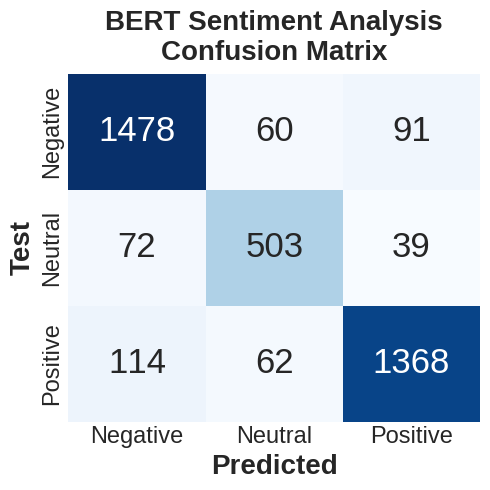

In [88]:
conf_matrix(y_test.argmax(1), y_pred_bert.argmax(1),'BERT Sentiment Analysis\nConfusion Matrix')

In [81]:
print('\tClassification Report for BERT:\n\n',classification_report(y_test,y_pred_bert, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for BERT:

               precision    recall  f1-score   support

    Negative       0.89      0.91      0.90      1629
     Neutral       0.80      0.82      0.81       614
    Positive       0.91      0.89      0.90      1544

   micro avg       0.88      0.88      0.88      3787
   macro avg       0.87      0.87      0.87      3787
weighted avg       0.88      0.88      0.88      3787
 samples avg       0.88      0.88      0.88      3787



# CNN Sentiment Analysis

In [107]:
# Define the CNN model
model = tf.keras.Sequential()
embedding_size = 50
num_filters = 64
kernel_size = 3  # Adjust this based on your preference
model.add(Embedding(input_dim=len(tokenizer.get_vocab()), output_dim=embedding_size, input_length=MAX_LEN, name='embedding_layer'))
model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))  # 3 classes for sentiment analysis
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_layer (Embedding  (None, 128, 50)           1526100   
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 126, 64)           9664      
                                                                 
 global_max_pooling1d_2 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_5 (Dense)             (None, 128)               8320      
                                                                 
 dropout_39 (Dropout)        (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 3)                

In [105]:
# Train the model
history = model.fit(train_input_ids, y_train, validation_data=(val_input_ids, y_valid), epochs=4, batch_size=32)

Epoch 1/4
1519/1519 [==============================] - 50s 32ms/step - loss: 0.6191 - accuracy: 0.7491 - val_loss: 0.4185 - val_accuracy: 0.8517
Epoch 2/4
1519/1519 [==============================] - 12s 8ms/step - loss: 0.2816 - accuracy: 0.9031 - val_loss: 0.3512 - val_accuracy: 0.8761
Epoch 3/4
1519/1519 [==============================] - 11s 7ms/step - loss: 0.1356 - accuracy: 0.9545 - val_loss: 0.3292 - val_accuracy: 0.8946
Epoch 4/4
1519/1519 [==============================] - 10s 6ms/step - loss: 0.0663 - accuracy: 0.9793 - val_loss: 0.3916 - val_accuracy: 0.8970


In [106]:
# Evaluate the model on the test set
y_pred = model.predict(test_input_ids)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

119/119 [==============================] - 0s 2ms/step


In [90]:
# Calculate accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.8170055452865065


In [93]:
# Calculate predictions from the CNN model
y_pred_cnn = model.predict(test_input_ids)
y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)
y_true_cnn_classes = np.argmax(y_test, axis=1)

119/119 [==============================] - 0s 4ms/step


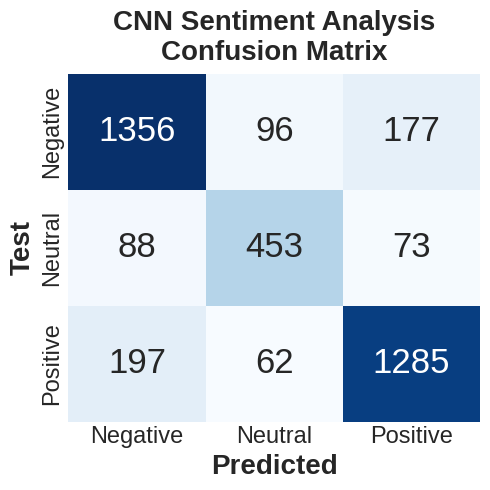

In [94]:
# Plot confusion matrix for CNN model
conf_matrix(y_test.argmax(1), y_pred_cnn.argmax(1), 'CNN Sentiment Analysis\nConfusion Matrix')

In [92]:
# Generate a classification report for the CNN
class_report_cnn = classification_report(y_true_cnn_classes, y_pred_cnn_classes, target_names=['Negative', 'Neutral', 'Positive'])
print("CNN Classification Report:")
print(class_report_cnn)

CNN Classification Report:
              precision    recall  f1-score   support

    Negative       0.83      0.83      0.83      1629
     Neutral       0.74      0.74      0.74       614
    Positive       0.84      0.83      0.83      1544

    accuracy                           0.82      3787
   macro avg       0.80      0.80      0.80      3787
weighted avg       0.82      0.82      0.82      3787



# Ensemble Model

In [96]:
# Ensemble by averaging predictions
y_pred_ensemble = (y_pred_bert + y_pred_cnn) / 2

In [97]:
# Convert ensemble predictions to class labels
y_pred_ensemble_classes = np.argmax(y_pred_ensemble, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

In [98]:
# Calculate accuracy for the ensemble model
ensemble_accuracy = accuracy_score(y_true_classes, y_pred_ensemble_classes)
print("Ensemble Model Accuracy:", ensemble_accuracy)

Ensemble Model Accuracy: 0.8843411671507789


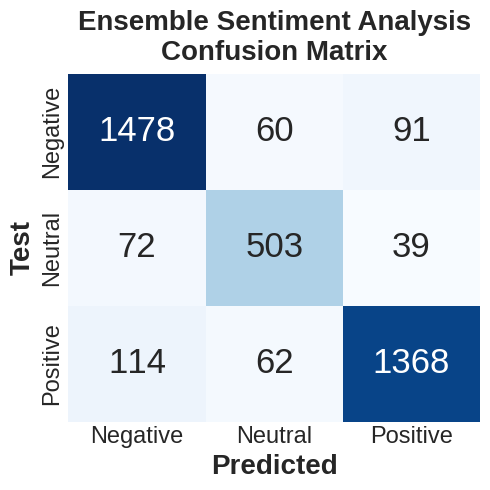

In [100]:
# Create a confusion matrix for the ensemble
conf_matrix(y_true_classes, y_pred_ensemble_classes, 'Ensemble Sentiment Analysis\nConfusion Matrix')

In [103]:
# Generate a classification report for the ensemble model
ensemble_class_report = classification_report(y_true_classes, y_pred_ensemble_classes, target_names=['Negative', 'Neutral', 'Positive'])
print("Ensemble Model Classification Report:")
print(ensemble_class_report)

Ensemble Model Classification Report:
              precision    recall  f1-score   support

    Negative       0.89      0.91      0.90      1629
     Neutral       0.80      0.82      0.81       614
    Positive       0.91      0.89      0.90      1544

    accuracy                           0.88      3787
   macro avg       0.87      0.87      0.87      3787
weighted avg       0.88      0.88      0.88      3787

